# NAMA : RENOL NINDI KARA NATASASMITA
# ASAL : MAJALENGKA
# EMAIL : renol.mangood@gmail.com

In [64]:
# IMPORT SEMUA LIBRARY YANG DIBUTUHKAN
import zipfile, os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

Dataset yang dipakai haruslah dataset berikut : rockpaperscissors, atau gunakan link ini pada wget command: https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip

Jika belum mendownload data nya jalankan code ini

!wget --no-check-certificate \
  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip \
  -O /tmp/rockpaperscissors.zip

In [65]:
#Extract ZIP
local_zip = '/tmp/rockpaperscissors.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Dataset harus dibagi menjadi train set dan validation set.

Ukuran validation set harus 40% dari total dataset (data training memiliki 1314 sampel, dan data validasi sebanyak 874 sampel).

In [66]:
# Split Folder
# Untuk Split Folder Disini saya pake library split-folders jadi install terlebih dahulu dengan cara buka cmd lalu ketikan "!pip install split-folders"
# untuk rasio nya disoal 40% untuk validation dan sisanya atau 60% untuk train
import splitfolders
splitfolders.ratio('/tmp/rockpaperscissors/rps-cv-images', output="/tmp/rockpaperscissors/result", seed=1337, ratio=(0.6, 0.4))

# Buat Directory train dan val
base_dir = '/tmp/rockpaperscissors/result'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')


Copying files: 0 files [00:00, ? files/s]
Copying files: 101 files [00:00, 960.36 files/s]
Copying files: 182 files [00:00, 889.08 files/s]
Copying files: 257 files [00:00, 841.62 files/s]
Copying files: 367 files [00:00, 905.26 files/s]
Copying files: 653 files [00:00, 1138.58 files/s]
Copying files: 939 files [00:00, 1374.15 files/s]
Copying files: 1113 files [00:00, 1166.75 files/s]
Copying files: 1261 files [00:01, 953.60 files/s] 
Copying files: 1385 files [00:01, 831.43 files/s]
Copying files: 1491 files [00:01, 753.22 files/s]
Copying files: 1584 files [00:01, 717.28 files/s]
Copying files: 1669 files [00:01, 710.10 files/s]
Copying files: 1749 files [00:01, 699.95 files/s]
Copying files: 1826 files [00:01, 701.11 files/s]
Copying files: 1901 files [00:02, 689.42 files/s]
Copying files: 1973 files [00:02, 665.47 files/s]
Copying files: 2042 files [00:02, 652.83 files/s]
Copying files: 2188 files [00:02, 893.87 files/s]


In [67]:
# Membuat Directory RSP(Rock Scissors Paper) pada directory train
train_rock_dir = os.path.join(train_dir, 'rock')
train_scissors_dir = os.path.join(train_dir, 'scissors')
train_paper_dir = os.path.join(train_dir, 'paper')

# Membuat Directory RSP(Rock Scissors Paper) pada directory val
validation_rock_dir = os.path.join(validation_dir, 'rock')
validation_scissors_dir = os.path.join(validation_dir, 'scissors')
validation_paper_dir = os.path.join(validation_dir, 'paper')

Harus mengimplementasikan augmentasi gambar.

Menggunakan image data generator.

In [68]:
# Membuat Augmentasi gambar dan menggunakan ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode = 'nearest',
)

test_datagen = ImageDataGenerator(
    rescale = 1./255,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest',
)

train_generator = train_datagen.flow_from_directory(
    train_dir,  # direktori data latih
    target_size=(150, 150),  # mengubah resolusi seluruh gambar menjadi 150x150 piksel
    batch_size=4,
    # karena kita merupakan masalah klasifikasi 3 kelas atau lebih maka menggunakan class_mode = 'sparse'
    class_mode='sparse'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir, # direktori data validasi
    target_size=(150, 150), # mengubah resolusi seluruh gambar menjadi 150x150 piksel
    batch_size=4,
    # karena kita merupakan masalah klasifikasi 3 kelas atau lebih maka menggunakan class_mode = 'sparse' 
    class_mode='sparse'
)

# Error pebandingan nya train image 1312 dan val image 876 setelah melihat forum diskusi bisa menggunakan 
# validation_split, split_folder, train_test_split dan ketiga cara tsb dibenarkan, https://www.dicoding.com/academies/184/discussions/72476

Found 1312 images belonging to 3 classes.
Found 876 images belonging to 3 classes.


Model harus menggunakan model sequential.

In [69]:
# Membangun Arsitektur CNN 
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])

Pelatihan model tidak melebihi waktu 30 menit. Jadi saya buat callback ketika accuracy dan val_accuracy sudah >= 0.96 atau 96% maka training akan dihentikan

In [70]:
# Buat Callback
class callbackFunc(tf.keras.callbacks.Callback):
    def __init__(self, min):
        super(callbackFunc, self).__init__()
        self.min = min

    def on_epoch_end(self, epoch, logs=None): 
        val_acc = logs["val_accuracy"]
        acc = logs["accuracy"]
        if val_acc and acc >= self.min:
            self.model.stop_training = True

# Minimum Akurasi 96%
call_back = callbackFunc(min=0.96)

In [71]:
# Compile model dengan optimizer RMSDrop(SARAN menggunakan optimizer dan loss-function yang tidak diajarkan di kelas) 
# dan sparse categorical crossentropy untuk loss function nya
model.compile(
    loss='sparse_categorical_crossentropy', # binary jika 2 kelas jika 3 kelas atau lebih pake sparse
    optimizer = tf.optimizers.RMSprop(),
    metrics=['accuracy']
)

# latih model dengan model.fit 
model.fit(
    train_generator,
    epochs=15, 
    validation_data=validation_generator, # menampilkan akurasi pengujian data validasi
    verbose=1,
    callbacks=[call_back]
)

Epoch 1/15
328/328 [==============================] - 73s 221ms/step - loss: 0.6811 - accuracy: 0.7218 - val_loss: 0.3994 - val_accuracy: 0.8573
Epoch 2/15
328/328 [==============================] - 72s 219ms/step - loss: 0.3313 - accuracy: 0.8925 - val_loss: 0.2951 - val_accuracy: 0.9075
Epoch 3/15
328/328 [==============================] - 74s 225ms/step - loss: 0.2564 - accuracy: 0.9177 - val_loss: 0.6170 - val_accuracy: 0.8299
Epoch 4/15
328/328 [==============================] - 71s 215ms/step - loss: 0.2442 - accuracy: 0.9245 - val_loss: 0.2205 - val_accuracy: 0.9452
Epoch 5/15
328/328 [==============================] - 71s 215ms/step - loss: 0.1881 - accuracy: 0.9398 - val_loss: 0.1622 - val_accuracy: 0.9669
Epoch 6/15
328/328 [==============================] - 71s 216ms/step - loss: 0.1876 - accuracy: 0.9474 - val_loss: 0.2726 - val_accuracy: 0.9521
Epoch 7/15
328/328 [==============================] - 70s 215ms/step - loss: 0.1424 - accuracy: 0.9649 - val_loss: 0.3877 - val_ac

Pengujian Dengan Gambar

Saving WhatsApp Image 2021-06-14 at 15.15.26.jpeg to WhatsApp Image 2021-06-14 at 15.15.26.jpeg
WhatsApp Image 2021-06-14 at 15.15.26.jpeg
scissors


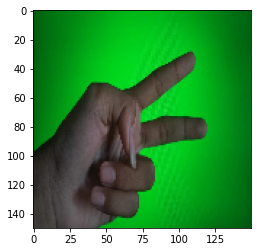

In [73]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
uploaded = files.upload()
 
for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
 
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  output_class = np.argmax(classes)
  print(fn)
  if output_class==0:
      print('paper')
  elif output_class==1:
      print('rock')
  else:
      print('scissors')
  